In [1]:
# Load needed packages
import numpy as np
import os
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import bokeh.palettes as palette # For palette of colors
import math
from scipy import stats
from matplotlib import rc
import ROOT 

# Latex rendering for plotting
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

# Define color palette
col = palette.brewer['RdYlBu'][10] #(8)

# Convert HTML color code to RGB
from PIL import ImageColor
ImageColor.getcolor(col[9], "RGB")

# Define folder to save plots
dir_name = './plots_relation'
if not os.path.isdir(dir_name):
    os.mkdir(dir_name)

Welcome to JupyROOT 6.22/02


<ipython-input-1-cb2c3fd763d5>:16: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r'\boldmath']


## Load data

In [2]:
# Compute bridge resistance errors
R1 = 11.98*10**3 # K Ohm
err_R1 = 1/np.sqrt(3)*np.sqrt( (0.009*R1)**2 + 0.001**2 )

R2 = 12.00*10**3 # K Ohm
err_R2 = 1/np.sqrt(3)*np.sqrt( (0.009*R2)**2 + 0.001**2 )

print('R1:', R1,'+-',err_R1)
print('R2:', R2,'+-',err_R2)

R1: 11980.0 +- 62.24990602670283
R2: 12000.0 +- 62.3538290751525


In [3]:
# LOAD DATASET

path_co = 'Data/rel_t_co.dat'
path_he = 'Data/rel_t_he.dat'
col_name = ['Tcf','Rv']

df_co = pd.read_csv(path_co, sep="\t", header=None, names=col_name,skiprows=4)
df_he = pd.read_csv(path_he, sep="\t", header=None, names=col_name,skiprows=4)

# Add error to Rv
df_co['err_Rv'] = 0.2/np.sqrt(12) 
df_he['err_Rv'] = 0.2/np.sqrt(12) 

In [4]:
# Convert Rv to RT and compute relative error
df_co['RT'] = R2/R1 * df_co['Rv']
df_co['err_RT'] = np.sqrt( (R2/R1 * df_co['err_Rv'])**2 + (df_co['Rv']/R1 * err_R2)**2 
                       + (R2/R1**2 * df_co['Rv'] * err_R1)**2 )

df_he['RT'] = R2/R1 * df_he['Rv']
df_he['err_RT'] = np.sqrt( (R2/R1 * df_he['err_Rv'])**2 + (df_he['Rv']/R1 * err_R2)**2 
                       + (R2/R1**2 * df_he['Rv'] * err_R1)**2 )

# Conversion curve parameters
conv_int = [33.61944053230692,0.11844094924462684]
conv_slo = [2.322727020253368,0.005259472243487998]

# Convert resistance RT to temperature 
df_co['Ts'] = conv_slo[0]*df_co['Rv'] + conv_int[0]
df_co['err_Ts'] = np.sqrt( conv_int[1]**2 + (df_co['RT']*conv_slo[1])**2 )

df_he['Ts'] = conv_slo[0]*df_he['Rv'] + conv_int[0]
df_he['err_Ts'] = np.sqrt( conv_int[1]**2 + (df_he['RT']*conv_slo[1])**2 )

df_co.describe()

,Tcf,Rv,err_Rv,RT,err_RT,Ts,err_Ts
count,82.000000,82.000000,8.200000e+01,82.000000,82.000000,82.000000,82.000000
mean,147.388016,53.463415,5.773503e-02,53.552669,0.398429,157.800358,0.308537
std,59.937815,20.233327,6.981595e-18,20.267106,0.147101,46.996496,0.097491
min,53.552000,22.000000,5.773503e-02,22.036728,0.171953,84.719435,0.165715
25%,94.094600,36.125000,5.773503e-02,36.185309,0.272123,117.527954,0.224162
50%,142.166500,50.500000,5.773503e-02,50.584307,0.376189,150.917155,0.291222
75%,200.952750,70.750000,5.773503e-02,70.868114,0.523974,197.952377,0.391095
max,251.052000,91.000000,5.773503e-02,91.151920,0.672319,244.987599,0.493825


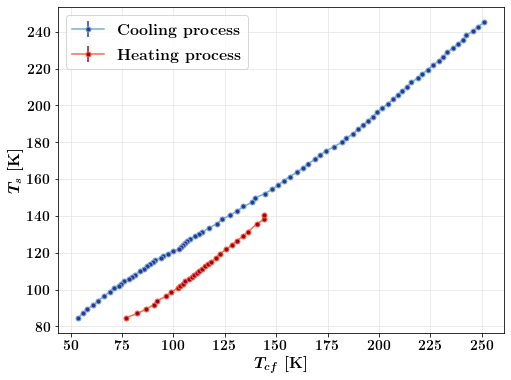

In [5]:
# Plot drift dataset

fig, ax = plt.subplots(1, 1, figsize=(8,6))

ax.errorbar(df_co['Tcf'],df_co['Ts'],yerr=df_co['err_Ts'],fmt='-o',markerfacecolor=col[0],
                color=col[2],ecolor=col[0],label=r'\bf{Cooling process}',alpha=1,markersize=5)

ax.errorbar(df_he['Tcf'],df_he['Ts'],yerr=df_he['err_Ts'],fmt='-o',markerfacecolor=col[9],
            color=col[7],ecolor=col[9],label=r'\bf{Heating process}',alpha=1,markersize=5)

#ax.set_title(r'\bf{R}', fontsize=20)
ax.set_ylabel(r'\bf{$T_{s}$ [K]}',fontsize=16)
ax.set_xlabel(r'\bf{$ T_{cf}$ [K]}',fontsize=16)
ax.grid(color='0.9')
#ax.set_ylim(335,435)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
plt.legend(loc='best',fontsize=16)
#ax.set_yticks(np.arange(340, 460, 20))
#ax.set_xticks(np.arange(80, 180, 20))
ax.set_axisbelow(True)

#plt.savefig(dir_name+'/drift_data.pdf', format='pdf',bbox_inches = "tight")

## Find linear relation between temperatures

In [6]:
def linear_fit(x,y,errx,erry,par_guess=[0,0]):

        
    f = ROOT.TF1("f", "pol1") # Define linear fit model
        
    g = ROOT.TGraphErrors(x.size, x.astype(np.double), y.astype(np.double), 
                              errx.astype(np.double), erry.astype(np.double))
        
    f.SetParameters(par_guess[0],par_guess[1]) # Set initial parameters
    fit = g.Fit('f','S',"")                    # Perform fit
      
    cov_ab = fit.GetCovarianceMatrix()[1,0] # Compute covariance term ab
    pcoeff = stats.pearsonr(x, y)           # Compute Pearson coefficient
        
        
    print('-------------------------------------------','\n')
    print('a: ', f.GetParameter(0),'+-',f.GetParError(0))
    print('b: ', f.GetParameter(1),'+-',f.GetParError(1),'\n')
    print('Chi2: ', f.GetChisquare())
    print('Ndf : ', f.GetNDF()      )
    print('Cov_ab: ',cov_ab)
    print('Pearson coefficient: ', pcoeff,'\n')
        
    print('-------------------------------------------')

    x_fit     = np.linspace(x[0], x[-1], 300)
    y_fit     = f.GetParameter(0) + f.GetParameter(1)*x_fit
    y_fit_res = f.GetParameter(0) + f.GetParameter(1)*x
        
    intercept = [f.GetParameter(0),f.GetParError(0)]
    slope     = [f.GetParameter(1),f.GetParError(1)]

    res = (y_fit_res - y)
    err_res = erry
        
    return(x_fit,y_fit,intercept,slope,res,err_res,cov_ab)  

------------------------------------------- 

a:  48.37689680208885 +- 0.2210260916172359
b:  0.7307694356025904 +- 0.0025271275008497606 

Chi2:  247.97962185375064
Ndf :  28
Cov_ab:  -0.0005497801352581232
Pearson coefficient:  (0.9985382300038744, 4.935807218547458e-37) 

-------------------------------------------
------------------------------------------- 

a:  16.59514140379298 +- 0.3092446078586793
b:  0.8337561324407118 +- 0.0028491731901534078 

Chi2:  262.59856007317603
Ndf :  24
Cov_ab:  -0.0008736300750854666
Pearson coefficient:  (0.9986780514827868, 1.8678015204514305e-32) 

-------------------------------------------


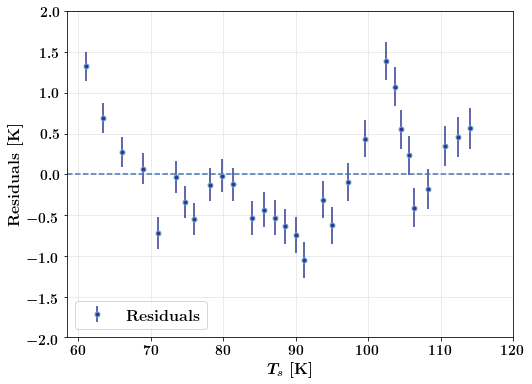

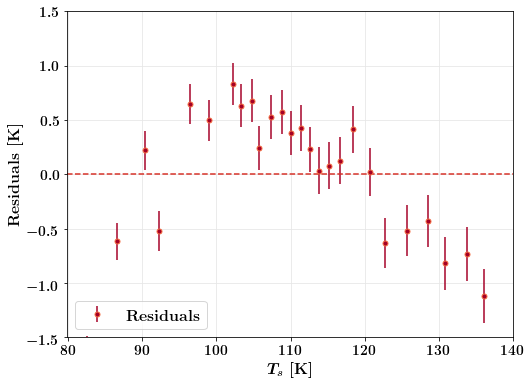

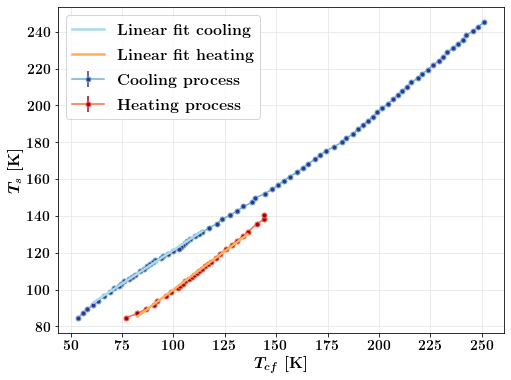


****************************************
Minimizer is Linear / Migrad
Chi2                      =       247.98
NDf                       =           28
p0                        =      48.3769   +/-   0.221026    
p1                        =     0.730769   +/-   0.00252713  

****************************************
Minimizer is Linear / Migrad
Chi2                      =      262.599
NDf                       =           24
p0                        =      16.5951   +/-   0.309245    
p1                        =     0.833756   +/-   0.00284917  


In [7]:
def fit_relation(range1,range2,par_guess):
    
    # Filter data for filtering background
    data = df_co[df_co['Tcf']>=range1[0]]
    data = data[data['Tcf']<=range1[1]]

    x = np.array(data['Tcf'])
    x_co = np.array(data['Tcf'])
    y = np.array(data['Ts'])
    errx = np.zeros(x.shape[0])
    erry = np.array(data['err_Ts'])

    # Perform linear fit
    x_fit_co, y_fit_co, intercept_co, slope_co, res_co, err_res_co, cov_co = linear_fit(x,y,errx,erry,par_guess)
 

    # Filter data for filtering background
    data = df_he[df_he['Tcf']>=range2[0]]
    data = data[data['Tcf']<=range2[1]]

    x = np.array(data['Tcf'])
    x_he = np.array(data['Tcf'])
    y = np.array(data['Ts'])
    errx = np.zeros(x.shape[0])
    erry = np.array(data['err_Ts'])

    # Perform linear fit
    x_fit_he, y_fit_he, intercept_he, slope_he, res_he, err_res_he, cov_he = linear_fit(x,y,errx,erry,par_guess)
    
    
    # PLOT RESULTS 
    
    # Plot residuals cooling
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    ax.errorbar(x_co,res_co,yerr=err_res_co,fmt='o',markerfacecolor=col[0],
                    color=col[2],ecolor=col[0],label=r'\bf{Residuals}',alpha=1,markersize=5)
    ax.axhline(0,color=col[1],ls='--')
    ax.set_xlabel(r'\bf{$T_{s}$ [K]}',fontsize=16)
    ax.set_ylabel(r'\bf{Residuals [K]}',fontsize=16)
    ax.grid(color='0.9')
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    plt.legend(loc='lower left',fontsize=16)
    ax.set_xticks(np.arange(60, 130, 10))
    ax.set_ylim(-2,2)
    ax.set_axisbelow(True)
    plt.savefig(dir_name+'/relation_res_co.pdf', format='pdf',bbox_inches = "tight")
    
    # Plot residuals heating
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    ax.errorbar(x_he,res_he,yerr=err_res_he,fmt='o',markerfacecolor=col[9],
                    color=col[7],ecolor=col[9],label=r'\bf{Residuals}',alpha=1,markersize=5)
    ax.axhline(0,color=col[8],ls='--')
    ax.set_xlabel(r'\bf{$T_{s}$ [K]}',fontsize=16)
    ax.set_ylabel(r'\bf{Residuals [K]}',fontsize=16)
    ax.grid(color='0.9')
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    plt.legend(loc='lower left',fontsize=16)
    ax.set_ylim(-1.5,1.5)
    ax.set_xticks(np.arange(80, 150, 10))
    ax.set_axisbelow(True)
    plt.savefig(dir_name+'/relation_res_he.pdf', format='pdf',bbox_inches = "tight")
    
    # Plot linear fit
    fig, ax = plt.subplots(1, 1, figsize=(8,6))

    ax.errorbar(df_co['Tcf'],df_co['Ts'],yerr=df_co['err_Ts'],fmt='-o',markerfacecolor=col[0],
                color=col[2],ecolor=col[0],label=r'\bf{Cooling process}',alpha=1,markersize=5)

    ax.errorbar(df_he['Tcf'],df_he['Ts'],yerr=df_he['err_Ts'],fmt='-o',markerfacecolor=col[9],
                color=col[7],ecolor=col[9],label=r'\bf{Heating process}',alpha=1,markersize=5)
    
    ax.plot(x_fit_co,y_fit_co,color=col[3],linewidth=2.5,label=r'\bf{Linear fit cooling}',zorder=3)
    ax.plot(x_fit_he,y_fit_he,color=col[6],linewidth=2.5,label=r'\bf{Linear fit heating}',zorder=3)
    
    #ax.set_title(r'\bf{Manual drift data}', fontsize=20)
    ax.set_ylabel(r'\bf{$T_{s}$ [K]}',fontsize=16)
    ax.set_xlabel(r'\bf{$ T_{cf}$ [K]}',fontsize=16)
    ax.grid(color='0.9')
    #ax.set_ylim(335,435)
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    plt.legend(loc='best',fontsize=16)
    #ax.set_yticks(np.arange(340, 460, 20))
    #ax.set_xticks(np.arange(80, 180, 20))
    ax.set_axisbelow(True)
    
    plt.savefig(dir_name+'/relation_t.pdf', format='pdf',bbox_inches = "tight")
    
    return(intercept_co, slope_co, intercept_he, slope_he)


intercept_co, slope_co, intercept_he, slope_he = fit_relation([60,115],[80,140],[100,2])

In [8]:
Tc_co = [80.29556458221417,1.4673560171590856]
Tc_he = [108.52688507915008,3.1866688452573317]

Tc_co_conv = [intercept_co[0] + slope_co[0] * Tc_co[0],
              np.sqrt( intercept_co[1]**2 + (slope_co[0]*Tc_co[1])**2 + (Tc_co[0]*slope_co[1])**2 )]

Tc_he_conv = [intercept_he[0] + slope_he[0] * Tc_he[0],
              np.sqrt( intercept_he[1]**2 + (slope_he[0]*Tc_he[1])**2 + (Tc_he[0]*slope_he[1])**2 )]
              
print('Tc_co arduino  :', Tc_co)
print('Tc_co converted:', Tc_co_conv[0],'+-',Tc_co_conv[1],'\n')
print('Tc_he arduino  :', Tc_he)
print('Tc_he converted:', Tc_he_conv[0],'+-',Tc_he_conv[1],'\n')

Tc_co arduino  : [80.29556458221417, 1.4673560171590856]
Tc_co converted: 107.05444121322485 +- 1.1134868147561814 

Tc_he arduino  : [108.52688507915008, 3.1866688452573317]
Tc_co converted: 107.08009737322274 +- 2.6926542226065378 



In [9]:
# Wighted average between cooling and heating Tc estimates

average = np.average([Tc_co_conv[0], Tc_he_conv[0]], weights=[1/(Tc_co_conv[1]**2), 1/(Tc_he_conv[1]**2)])
error_average = np.sqrt( 1/(1/(Tc_co_conv[1]**2)+1/(Tc_he_conv[1]**2)) )

compatibility = np.abs(Tc_co_conv[0]-Tc_he_conv[0])/np.sqrt(Tc_co_conv[1]**2+Tc_he_conv[1]**2)

print('Weighted average:', average,'+-',error_average)
print('Compatibility:', compatibility)

Weighted average: 107.05818785234786 +- 1.0289770565972876
Compatibility: 0.008805047046325494
